<a href="https://colab.research.google.com/github/luunguyen3105/Sentiment_Analysis_INT3209E/blob/main/Submit1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install pyvi


     |████████████████████████████████| 8.5 MB 26.4 MB/s 
     |████████████████████████████████| 743 kB 61.3 MB/s 


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM, GRU, Input, GlobalMaxPool1D, LayerNormalization, Concatenate, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import  Adam, SGD
from tensorflow.keras import Sequential, preprocessing, callbacks
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyvi import ViTokenizer
from pyvi import ViUtils
from tensorflow.keras.callbacks import ModelCheckpoint
import seaborn as sns

In [ ]:
callback_model = tf.keras.callbacks.ModelCheckpoint('model_cnn_bilstm.h5', monitor='val_loss')

In [5]:
df = pd.read_csv('/content/mycsvfile.csv')
df

,sentence,label
0,Good ratio price/service. Good advices for the...,__label__tot
1,Trang thiết bị vệ sinh hơi cũ. Vệ sinh sạch sẽ...,__label__trung_binh
2,Friendly staff. Helpful for booking tours. Roo...,__label__xuat_sac
3,Quá ồn ào . Thất vọng,__label__kem
4,Nice place to be to get around Staff really ta...,__label__tot
...,...,...
22994,"Bãi tắm cách khách sạn Green World Nha Trang, ...",__label__tot
22995,"Khách sạn phục vụ khá tốt, chỉ có vấn đề nhận ...",__label__tot
22996,Cám ơn Dịch vụ Chudu24 và bạn Nga nhiều nhé.Gi...,__label__tot
22997,"Khách sạn mới, đẹp, phòng sạch sẽ.nhân viên th...",__label__tot


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


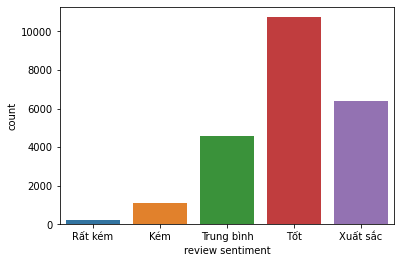

In [6]:
def to_sentiment(label):
  rating = str(label)
  if rating == '__label__xuat_sac': 
    return 4
  elif rating == '__label__tot':
    return 3
  elif rating == '__label__trung_binh':
    return 2
  elif rating == '__label__kem':
    return 1
  elif rating == '__label__rat_kem':
    return 0

df['sentiment'] = df.label.apply(to_sentiment)
class_names = ['Rất kém', 'Kém', 'Trung bình', 'Tốt', "Xuất sắc"]
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [7]:
input_data = df['sentence'].values
input_label = df['label'].values

input_pre = []
label_with_accent = []
for idx, dt in enumerate(input_data):
  input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(dt))
  input_text_pre = " ".join(input_text_pre)
  input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
  input_text_pre_no_accent = str(ViUtils.remove_accents(input_text_pre).decode("utf-8"))
  input_text_pre_no_accent = ViTokenizer.tokenize(input_text_pre_no_accent)
  input_pre.append(input_text_pre_accent)
  input_pre.append(input_text_pre_no_accent)
  label_with_accent.append(input_label[idx])
  label_with_accent.append(input_label[idx])

In [ ]:
input_pre


In [11]:
label_dict = {
    '__label__xuat_sac': 4,
    '__label__tot': 3,
    '__label__trung_binh': 2,
    '__label__kem': 1,
    '__label__rat_kem': 0

}

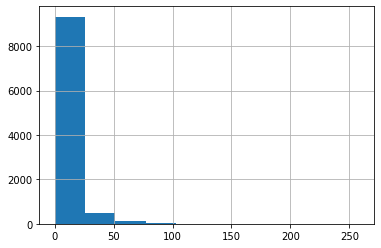

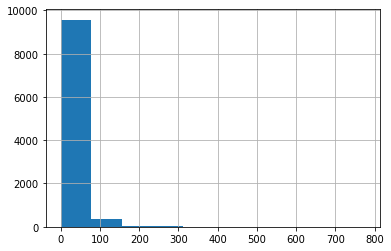

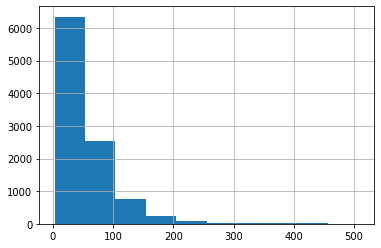

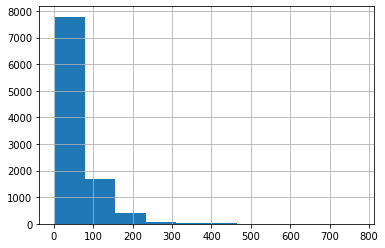

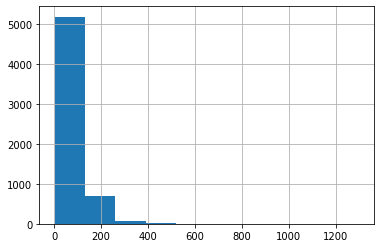

In [12]:
seq_len = [len(i.split()) for i in input_pre[0:10000]]
pd.Series(seq_len).hist(bins = 10)
plt.show()

seq_len = [len(i.split()) for i in input_pre[10000:20000]]
pd.Series(seq_len).hist(bins = 10)
plt.show()

seq_len = [len(i.split()) for i in input_pre[20000:30000]]
pd.Series(seq_len).hist(bins = 10)
plt.show()

seq_len = [len(i.split()) for i in input_pre[30000:40000]]
pd.Series(seq_len).hist(bins = 10)
plt.show()

seq_len = [len(i.split()) for i in input_pre[40000:50000]]
pd.Series(seq_len).hist(bins = 10)
plt.show()

Dựa vào bảng thống kê số liệu, ta lựa chọn max_len = 512

In [17]:
label_idx = [label_dict[i] for i in label_with_accent]
label_tf = tf.keras.utils.to_categorical(label_idx, num_classes=5, dtype='float32')

In [18]:
label_tf

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [19]:
tokenizer_data = Tokenizer(oov_token='<OOV>', filters='', split=' ')
tokenizer_data.fit_on_texts(input_pre)

In [ ]:
tokenizer_data_text = tokenizer_data.texts_to_sequences(input_pre)
vec_data = pad_sequences(tokenizer_data_text, padding='post', maxlen = 512)

In [ ]:
vec_data


array([[ 178, 6710,  703, ...,    0,    0,    0],
       [ 178, 6710,  703, ...,    0,    0,    0],
       [ 128,  536,  523, ...,    0,    0,    0],
       ...,
       [   2,    3,   93, ...,    0,    0,    0],
       [   7,  160,  237, ...,    0,    0,    0],
       [   2,    3,  107, ...,    0,    0,    0]], dtype=int32)

In [ ]:
pickle.dump(tokenizer_data, open("tokenizer_data.pkl", "wb"))

In [ ]:
print("input data.shape: ", vec_data.shape)
data_vocab_size = len(tokenizer_data.word_index) + 1
print("data_vocab_size: ", data_vocab_size)

input data.shape:  (45998, 512)
data_vocab_size:  40548


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(vec_data, label_tf, test_size = 0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.1, random_state=42)
print("training sample: ", len(X_train))
print("validation sample: ", len(X_val))
print("test sample: ", len(X_test))

training sample:  33118
validation sample:  9200
test sample:  3680


In [ ]:

def generate_model():
  dropout_threshold = 0.4
  input_dim = data_vocab_size
  output_dim = 32
  input_length = 512
  initializer = tf.keras.initializers.GlorotNormal()

  input_layer = Input(shape=(input_length))
  feature =  Embedding(
      input_dim     = input_dim, 
      output_dim    = output_dim,
      input_length  = input_length,
      embeddings_initializer = 'GlorotNormal'
  )(input_layer)
  cnn_feature = Conv1D(filters=32, kernel_size= 3, padding = 'same', activation='relu')(feature)
  cnn_feature = MaxPooling1D()(cnn_feature)
  cnn_feature = Dropout(dropout_threshold)(cnn_feature)
  cnn_feature = Conv1D(filters=32, kernel_size = 3, padding = 'same', activation='relu')(cnn_feature)
  cnn_feature = MaxPooling1D()(cnn_feature)
  cnn_feature = LayerNormalization()(cnn_feature)
  cnn_feature = Dropout(dropout_threshold)(cnn_feature)

  bi_lstm_feature = Bidirectional(LSTM(
      units=32,
      dropout=dropout_threshold,
      return_sequences=True,
      kernel_initializer=initializer
      ), merge_mode = 'concat'
  )(feature)
  bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)

  bi_lstm_feature = Bidirectional(GRU(
      units=32,
      dropout=dropout_threshold,
      return_sequences=True,
      kernel_initializer=initializer
      ), merge_mode = 'concat'
  )(bi_lstm_feature)
  bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)
  bi_lstm_feature = LayerNormalization()(bi_lstm_feature)

  combine_feature = tf.keras.layers.Concatenate()([cnn_feature, bi_lstm_feature])
  combine_feature = GlobalMaxPool1D()(combine_feature)
  combine_feature = LayerNormalization()(combine_feature)

  classifier = Dense(90, activation= 'relu')(combine_feature)
  classifier = Dropout(0.2)(classifier)
  classifier = Dense(70, activation= 'relu')(classifier)
  classifier = Dropout(0.2)(classifier)
  classifier = Dense(50, activation= 'relu')(classifier)
  classifier = Dropout(0.2)(classifier)
  classifier = Dense(30, activation= 'relu')(classifier)
  classifier = Dropout(0.2)(classifier)
  classifier = Dense(5, activation= 'softmax')(classifier)

  model = tf.keras.Model(inputs = input_layer, outputs = classifier)
  return model

model = generate_model()
adam = Adam(learning_rate = 0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 512, 32)      1297536     ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 512, 32)      3104        ['embedding[0][0]']              
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 256, 32)      0           ['conv1d[0][0]']                 
                                                                                              

In [ ]:
history = model.fit(x = X_train, y = y_train, validation_data = (X_val, y_val), epochs=25, batch_size = 128, callbacks=[callback_model])

Epoch 1/25
259/259 [==============================] - 330s 1s/step - loss: 0.4065 - accuracy: 0.8423 - val_loss: 0.8601 - val_accuracy: 0.7064
Epoch 2/25
259/259 [==============================] - 329s 1s/step - loss: 0.3881 - accuracy: 0.8502 - val_loss: 0.8920 - val_accuracy: 0.7088
Epoch 3/25
259/259 [==============================] - 329s 1s/step - loss: 0.3689 - accuracy: 0.8571 - val_loss: 0.9786 - val_accuracy: 0.7096
Epoch 4/25
259/259 [==============================] - 329s 1s/step - loss: 0.3541 - accuracy: 0.8624 - val_loss: 1.0896 - val_accuracy: 0.7060
Epoch 5/25
259/259 [==============================] - 330s 1s/step - loss: 0.3408 - accuracy: 0.8675 - val_loss: 1.0388 - val_accuracy: 0.7014
Epoch 6/25
259/259 [==============================] - 329s 1s/step - loss: 0.3285 - accuracy: 0.8702 - val_loss: 1.1691 - val_accuracy: 0.7050
Epoch 7/25
259/259 [==============================] - 332s 1s/step - loss: 0.3196 - accuracy: 0.8748 - val_loss: 1.2333 - val_accuracy: 0.7060

In [ ]:
model.load_weights("/content/sample_data/model_cnn_bilstm.h5")
model.evaluate(X_test, y_test)

115/115 [==============================] - 16s 114ms/step - loss: 1.7201 - accuracy: 0.6886


[1.7201188802719116, 0.688586950302124]

In [ ]:
def preprocess_raw_input(raw_input, tokenizer):
  input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(raw_input))
  input_text_pre = " ".join(input_text_pre)
  input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
  #print("Text_preprocessed:", input_text_pre_accent)
  tokenized_data_text = tokenizer.texts_to_sequences([input_text_pre_accent])
  vec_data = pad_sequences(tokenized_data_text, padding='post',maxlen=512)
  return vec_data

def inference_model(input_feature, model):
  output = model(input_feature).numpy()[0]
  result = output.argmax()
  conf = float(output.max())
  label_dict = {'Rất kém': 0, 'Kém': 1, 'Trung bình': 2, 'Tốt': 3, 'Xuất sắc' : 4}
  label = list(label_dict.keys())
  return label[int(result)], conf 

def prediction(raw_input, tokenizer, model):
  input_model = preprocess_raw_input(raw_input, tokenizer_data)
  result, conf = inference_model(input_model, model)

  return str(result), conf

my_model = generate_model()
my_model = load_model('/content/sample_data/model_cnn_bilstm.h5')

with open(r"tokenizer_data.pkl","rb") as input_file:
  my_tokenizer = pickle.load(input_file)




('Trung bình', 0.8083905577659607)


In [ ]:
print(prediction("Khách sạn tiêu chuẩn, nhưng phục vụ kém.Điểm hình tổ chức tiệc buffet đêm giao thừa,lượng người không quá đông, nhưng khâu chuẩn bị lủng củng, nhân viên chưa niềm nở với khách, thức ăn không được tươi ngon, phục vụ không đúng như thực đơn buffet ( nói tổng thể là khách sạn tiêu chuẩn phục vụ không chuẩn) . Phục vụ và ăn uống", my_tokenizer,my_model))

In [ ]:
filename = '/content/test_end.txt'

In [ ]:
with open(filename) as file:
    lines = file.readlines()
    lines = [line.rstrip() for line in lines]

In [ ]:
samples = []
prediction_datas = []
prediction_accs = []
for line in lines:
    sample = str(line)
    prediction_data = prediction(str(line), my_tokenizer, my_model)[0]
    samples.append(sample)
    prediction_datas.append(prediction_data)
    prediction_acc = prediction(sample, my_tokenizer, my_model)[1]
    prediction_accs.append(prediction_acc)
    #file['predicted_sentiment'] = file.prediction(sample, my_tokenizer, my_model)

In [ ]:
df_test = pd.DataFrame({'sample': samples, 'prediction': prediction_datas, 'accuracy': prediction_accs}) 
df_test


,sample,prediction,accuracy
0,Great central position to old market area. Ver...,Xuất sắc,0.992331
1,Service..did it all. Helpful in everytging . T...,Xuất sắc,1.000000
2,"Kiến trúc ở Tam Giang resort & Spa sang trọng,...",Xuất sắc,0.999977
3,Sàn nhà ở khách sạn chưa được sạch sẽ lắm nhưn...,Tốt,0.780785
4,Khách sạn có phòng rất đẹp và sạch sẽ. Nhân vi...,Xuất sắc,0.840933
...,...,...,...
236,"Khách sạn nằm sát biển, rất thuận lợi cho việc...",Tốt,0.680873
237,Khách sạn này có giá tương đối tốt. Phòng ốc l...,Tốt,0.999969
238,"Một ngày nghỉ ở đây thật chán, nhân viên phục ...",Tốt,0.545667
239,Tôi đã đi nhiều nơi và nghỉ ở nhiều khách sạn ...,Xuất sắc,0.843763


In [ ]:
#df_test.to_csv('./myPredictfile26.csv',index=False)

In [ ]:
while(True):
  text = input()
  if text == "end":
    break
  else:
    print(prediction(text, my_tokenizer, my_model)[0]+"\n") 


In [ ]:
samples = []
for line in lines:
    sample = str(line)
    samples.append(sample)

In [ ]:
df['prediction'] = df['sample'].apply(prediction(sample, my_tokenizer, my_model)[0])